# Plot joint deterministic inversion for shear modulus structure variations and fault slip as a function fault geometry uncertainties 

This notebook plots the results of several joint adjoint-based deterministic inversions by varying the dip angle within the fault geometry.  


In [1]:
# Import libraries
import dolfin as dl
import ufl
import math
import numpy as np
import pandas as pd
# Import libraries for plotting
from cmcrameri import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.tri as tri
from matplotlib.patches import Polygon
import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif', size=16)
rc('legend', fontsize=16)
TINY_SIZE = 14
SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

import sys, os
#sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "...") )
import hippylib as hp

from pointwiseStateObs import PointwiseStateObservation
# Load TV regularization class and observation operator
from TVprior_Joint import *
from FunctionsIO import FunctionsIO

# Define folders directory 
meshpath = "../mesh/"
savepath = "./results_Joint_FaultDip/"
# Size domain
xmin = -700.; xmax = 400.; ymin = -500.; ymax = 0.
# Degree 
k = 2
# Define sep
sep = "\n"+"#"*80+"\n"


In [3]:
# Load colormap from Paraview
model_name = "Blue_Orange.txt"
BuOr = pd.read_csv(model_name, delimiter=' ',
                    names=['r', 'g', 'b'])

my_cmap = mpl.colors.ListedColormap(np.flip( np.array(BuOr)/255., 0 ), name='BuOr')


In [4]:
# Define a function to extract the function spaces
def FunctionSpaces(mesh, k, verbose=True):
    # Define function spaces
    # Use VectorFunctionSpace if the unknown is a vector field.
    # Use FunctionSpace object for scalar fields.
    BDM = dl.VectorFunctionSpace(mesh, "BDM", k)    # stress (tensor field, since BDM is a vector field)
    DGv = dl.VectorFunctionSpace(mesh, "DG", k-1)   # displacement (vector field)
    DGr = dl.FunctionSpace(mesh, "DG", k-1)         # rotation (scalar field)
    ME_element = dl.MixedElement([BDM.ufl_element(), DGv.ufl_element(), DGr.ufl_element()])
    Vu = dl.FunctionSpace(mesh, ME_element)
    n = dl.FacetNormal(mesh)
    # Define mixed function spaces for the model parameters
    CG = dl.FunctionSpace(mesh, "CG", 1)
    CG_element = dl.MixedElement([CG.ufl_element(), CG.ufl_element()])
    Vm = dl.FunctionSpace(mesh, CG_element)
    # Combine the STATE, PARAMETER and ADJOINT function spaces
    Vh = [Vu, Vm, Vu]
    # Print the dofs of STATE, PARAMETER and ADJOINT variables
    ndofs = [ Vh[hp.STATE].dim(), Vh[hp.PARAMETER].dim(), Vh[hp.ADJOINT].dim() ]
    ndofs_state = [ Vu.sub(0).dim(), Vu.sub(1).dim(), Vu.sub(2).dim() ]
    if verbose:
        print( sep, "Set up the mesh and finite element spaces", sep )
        print( "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(*ndofs) )
        print( "Number of STATE and ADJOINT dofs: STRESS={0}, DISPLACEMENT={1}, ROTATION={2}".format(*ndofs_state) )

        
    return Vh, CG
    

In [5]:
# Define the axes range
lef, rig, topp, bot = -200., 100., 0., -150.
GPa2Pa = 1e9
mu_b = 24.4                # shear modulus background
mu_background = np.exp(mu_b)
mu_a = 24.0                # shear modulus anomaly
mu_anomaly = np.exp(mu_a)
print( "The shear modulus for the anomaly is: mu = %.2f GPa while the background mu = %.2f GPa" %(mu_anomaly/GPa2Pa, mu_background/GPa2Pa) )

# Generate random surface observations
ntargets = 20
targets_x = np.linspace(-180., 0., ntargets) 
targets_y = (ymax-dl.DOLFIN_EPS)*np.ones(ntargets)
targets = np.zeros([ntargets, 2])
targets[:,0] = targets_x; targets[:,1] = targets_y

# Define colormaps and level for contourf
cmap_1 = plt.get_cmap("Oranges_r")
cmap_2 = plt.get_cmap("viridis", 21)
cmap_3 = plt.get_cmap("RdBu_r")
cmap_4 = plt.get_cmap("RdBu_r", 21)
levels_ux = np.linspace(-4., 4., 21)
levels_uy = np.linspace(-4., 4., 21)
levels_m = np.linspace(mu_anomaly/GPa2Pa, (mu_background-1e6)/GPa2Pa, 21)
colors = [ cmap_1(0.3), cmap_1(0.6), cmap_1(0.9) ]

# Create a perimeter of the triangular anomaly
xy_triangle = np.array([ [-160.0,-5.0], [-30.0,-5.0], [-95.0, -55.0] ]) 

# For labels of subplots (a,b,c,d)
props = dict(boxstyle='round', lw=0.25, facecolor='ivory', alpha=0.95)


The shear modulus for the anomaly is: mu = 26.49 GPa while the background mu = 39.52 GPa


In [6]:
fault_dip = 45

# Mesh
name = "Mesh_StraightFault_dip" + str(fault_dip) + "_Triangle"
mesh_45 = dl.Mesh(meshpath + name + '.xml')
Vh_45, CG_45 = FunctionSpaces(mesh_45, k, verbose=True)

# Load results to HDF5
namefolder = "fault_dip" + str(fault_dip) + "_Triangle/"
path = savepath + namefolder

# Parameters
filename = 'm_mu'
function_names = ['true', 'inferred']
all_funs = FunctionsIO.read(mesh_45.mpi_comm(), path + filename, CG_45, function_names)
mu_true_45 = all_funs[0]
m_mu_45 = all_funs[1]

# Fault
filename = 'fault_geometry.txt'
fault_45 = pd.read_csv(path + filename, delimiter=' ')
xf_45, yf_45 = fault_45['xf'], fault_45['yf']

# Slip
filename = 'm_s.txt'
slip_45 = pd.read_csv(path + filename, delimiter=' ')
s_true_45, m_s_45 = slip_45['true'], slip_45['cal']

# Observed data
filename = 'data.txt'
data_45 = pd.read_csv(path + filename, delimiter=' ')



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=111168, PARAMETER=4760, ADJOINT=111168
Number of STATE and ADJOINT dofs: STRESS=69642, DISPLACEMENT=27684, ROTATION=13842


In [7]:
fault_dip = 40

# Mesh
name = "Mesh_StraightFault_dip" + str(fault_dip) + "_Triangle"
mesh_40 = dl.Mesh(meshpath + name + '.xml')
Vh_40, CG_40 = FunctionSpaces(mesh_40, k, verbose=True)

# Load results to HDF5
namefolder = "fault_dip" + str(fault_dip) + "_Triangle/"
path = savepath + namefolder

# Parameters
filename = 'm_mu'
function_names = ['true', 'inferred']
all_funs = FunctionsIO.read(mesh_40.mpi_comm(), path + filename, CG_40, function_names)
mu_true_40 = all_funs[0]
m_mu_40 = all_funs[1]

# Fault
filename = 'fault_geometry.txt'
fault_40 = pd.read_csv(path + filename, delimiter=' ')
xf_40, yf_40 = fault_40['xf'], fault_40['yf']

# Slip
filename = 'm_s.txt'
slip_40 = pd.read_csv(path + filename, delimiter=' ')
s_true_40, m_s_40 = slip_40['true'], slip_40['cal']

# Observed data
filename = 'data.txt'
data_40 = pd.read_csv(path + filename, delimiter=' ')



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=107376, PARAMETER=4602, ADJOINT=107376
Number of STATE and ADJOINT dofs: STRESS=67272, DISPLACEMENT=26736, ROTATION=13368


In [8]:
fault_dip = 41

# Mesh
name = "Mesh_StraightFault_dip" + str(fault_dip) + "_Triangle"
mesh_41 = dl.Mesh(meshpath + name + '.xml')
Vh_41, CG_41 = FunctionSpaces(mesh_41, k, verbose=True)

# Load results to HDF5
namefolder = "fault_dip" + str(fault_dip) + "_Triangle/"
path = savepath + namefolder

# Parameters
filename = 'm_mu'
function_names = ['true', 'inferred']
all_funs = FunctionsIO.read(mesh_41.mpi_comm(), path + filename, CG_41, function_names)
mu_true_41 = all_funs[0]
m_mu_41 = all_funs[1]

# Fault
filename = 'fault_geometry.txt'
fault_41 = pd.read_csv(path + filename, delimiter=' ')
xf_41, yf_41 = fault_41['xf'], fault_41['yf']

# Slip
filename = 'm_s.txt'
slip_41 = pd.read_csv(path + filename, delimiter=' ')
s_true_41, m_s_41 = slip_41['true'], slip_41['cal']

# Observed data
filename = 'data.txt'
data_41 = pd.read_csv(path + filename, delimiter=' ')



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=107424, PARAMETER=4604, ADJOINT=107424
Number of STATE and ADJOINT dofs: STRESS=67302, DISPLACEMENT=26748, ROTATION=13374


In [9]:
fault_dip = 42

# Mesh
name = "Mesh_StraightFault_dip" + str(fault_dip) + "_Triangle"
mesh_42 = dl.Mesh(meshpath + name + '.xml')
Vh_42, CG_42 = FunctionSpaces(mesh_42, k, verbose=True)

# Load results to HDF5
namefolder = "fault_dip" + str(fault_dip) + "_Triangle/"
path = savepath + namefolder

# Parameters
filename = 'm_mu'
function_names = ['true', 'inferred']
all_funs = FunctionsIO.read(mesh_42.mpi_comm(), path + filename, CG_42, function_names)
mu_true_42 = all_funs[0]
m_mu_42 = all_funs[1]

# Fault
filename = 'fault_geometry.txt'
fault_42 = pd.read_csv(path + filename, delimiter=' ')
xf_42, yf_42 = fault_42['xf'], fault_42['yf']

# Slip
filename = 'm_s.txt'
slip_42 = pd.read_csv(path + filename, delimiter=' ')
s_true_42, m_s_42 = slip_42['true'], slip_42['cal']

# Observed data
filename = 'data.txt'
data_42 = pd.read_csv(path + filename, delimiter=' ')



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=108096, PARAMETER=4632, ADJOINT=108096
Number of STATE and ADJOINT dofs: STRESS=67722, DISPLACEMENT=26916, ROTATION=13458


In [10]:
fault_dip = 43

# Mesh
name = "Mesh_StraightFault_dip" + str(fault_dip) + "_Triangle"
mesh_43 = dl.Mesh(meshpath + name + '.xml')
Vh_43, CG_43 = FunctionSpaces(mesh_43, k, verbose=True)

# Load results to HDF5
namefolder = "fault_dip" + str(fault_dip) + "_Triangle/"
path = savepath + namefolder

# Parameters
filename = 'm_mu'
function_names = ['true', 'inferred']
all_funs = FunctionsIO.read(mesh_43.mpi_comm(), path + filename, CG_43, function_names)
mu_true_43 = all_funs[0]
m_mu_43 = all_funs[1]

# Fault
filename = 'fault_geometry.txt'
fault_43 = pd.read_csv(path + filename, delimiter=' ')
xf_43, yf_43 = fault_43['xf'], fault_43['yf']

# Slip
filename = 'm_s.txt'
slip_43 = pd.read_csv(path + filename, delimiter=' ')
s_true_43, m_s_43 = slip_43['true'], slip_43['cal']

# Observed data
filename = 'data.txt'
data_43 = pd.read_csv(path + filename, delimiter=' ')



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=109968, PARAMETER=4710, ADJOINT=109968
Number of STATE and ADJOINT dofs: STRESS=68892, DISPLACEMENT=27384, ROTATION=13692


In [11]:
fault_dip = 44

# Mesh
name = "Mesh_StraightFault_dip" + str(fault_dip) + "_Triangle"
mesh_44 = dl.Mesh(meshpath + name + '.xml')
Vh_44, CG_44 = FunctionSpaces(mesh_44, k, verbose=True)

# Load results to HDF5
namefolder = "fault_dip" + str(fault_dip) + "_Triangle/"
path = savepath + namefolder

# Parameters
filename = 'm_mu'
function_names = ['true', 'inferred']
all_funs = FunctionsIO.read(mesh_44.mpi_comm(), path + filename, CG_44, function_names)
mu_true_44 = all_funs[0]
m_mu_44 = all_funs[1]

# Fault
filename = 'fault_geometry.txt'
fault_44 = pd.read_csv(path + filename, delimiter=' ')
xf_44, yf_44 = fault_44['xf'], fault_44['yf']

# Slip
filename = 'm_s.txt'
slip_44 = pd.read_csv(path + filename, delimiter=' ')
s_true_44, m_s_44 = slip_44['true'], slip_44['cal']

# Observed data
filename = 'data.txt'
data_44 = pd.read_csv(path + filename, delimiter=' ')



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=110736, PARAMETER=4742, ADJOINT=110736
Number of STATE and ADJOINT dofs: STRESS=69372, DISPLACEMENT=27576, ROTATION=13788


In [12]:
fault_dip = 46

# Mesh
name = "Mesh_StraightFault_dip" + str(fault_dip) + "_Triangle"
mesh_46 = dl.Mesh(meshpath + name + '.xml')
Vh_46, CG_46 = FunctionSpaces(mesh_46, k, verbose=True)

# Load results to HDF5
namefolder = "fault_dip" + str(fault_dip) + "_Triangle/"
path = savepath + namefolder

# Parameters
filename = 'm_mu'
function_names = ['true', 'inferred']
all_funs = FunctionsIO.read(mesh_46.mpi_comm(), path + filename, CG_46, function_names)
mu_true_46 = all_funs[0]
m_mu_46 = all_funs[1]

# Fault
filename = 'fault_geometry.txt'
fault_46 = pd.read_csv(path + filename, delimiter=' ')
xf_46, yf_46 = fault_46['xf'], fault_46['yf']

# Slip
filename = 'm_s.txt'
slip_46 = pd.read_csv(path + filename, delimiter=' ')
s_true_46, m_s_46 = slip_46['true'], slip_46['cal']

# Observed data
filename = 'data.txt'
data_46 = pd.read_csv(path + filename, delimiter=' ')



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=112176, PARAMETER=4802, ADJOINT=112176
Number of STATE and ADJOINT dofs: STRESS=70272, DISPLACEMENT=27936, ROTATION=13968


In [13]:
fault_dip = 47

# Mesh
name = "Mesh_StraightFault_dip" + str(fault_dip) + "_Triangle"
mesh_47 = dl.Mesh(meshpath + name + '.xml')
Vh_47, CG_47 = FunctionSpaces(mesh_47, k, verbose=True)

# Load results to HDF5
namefolder = "fault_dip" + str(fault_dip) + "_Triangle/"
path = savepath + namefolder

# Parameters
filename = 'm_mu'
function_names = ['true', 'inferred']
all_funs = FunctionsIO.read(mesh_47.mpi_comm(), path + filename, CG_47, function_names)
mu_true_47 = all_funs[0]
m_mu_47 = all_funs[1]

# Fault
filename = 'fault_geometry.txt'
fault_47 = pd.read_csv(path + filename, delimiter=' ')
xf_47, yf_47 = fault_47['xf'], fault_47['yf']

# Slip
filename = 'm_s.txt'
slip_47 = pd.read_csv(path + filename, delimiter=' ')
s_true_47, m_s_47 = slip_47['true'], slip_47['cal']

# Observed data
filename = 'data.txt'
data_47 = pd.read_csv(path + filename, delimiter=' ')



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=112608, PARAMETER=4820, ADJOINT=112608
Number of STATE and ADJOINT dofs: STRESS=70542, DISPLACEMENT=28044, ROTATION=14022


In [14]:
fault_dip = 48

# Mesh
name = "Mesh_StraightFault_dip" + str(fault_dip) + "_Triangle"
mesh_48 = dl.Mesh(meshpath + name + '.xml')
Vh_48, CG_48 = FunctionSpaces(mesh_48, k, verbose=True)

# Load results to HDF5
namefolder = "fault_dip" + str(fault_dip) + "_Triangle/"
path = savepath + namefolder

# Parameters
filename = 'm_mu'
function_names = ['true', 'inferred']
all_funs = FunctionsIO.read(mesh_48.mpi_comm(), path + filename, CG_48, function_names)
mu_true_48 = all_funs[0]
m_mu_48 = all_funs[1]

# Fault
filename = 'fault_geometry.txt'
fault_48 = pd.read_csv(path + filename, delimiter=' ')
xf_48, yf_48 = fault_48['xf'], fault_48['yf']

# Slip
filename = 'm_s.txt'
slip_48 = pd.read_csv(path + filename, delimiter=' ')
s_true_48, m_s_48 = slip_48['true'], slip_48['cal']

# Observed data
filename = 'data.txt'
data_48 = pd.read_csv(path + filename, delimiter=' ')



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=113472, PARAMETER=4856, ADJOINT=113472
Number of STATE and ADJOINT dofs: STRESS=71082, DISPLACEMENT=28260, ROTATION=14130


In [15]:
fault_dip = 49

# Mesh
name = "Mesh_StraightFault_dip" + str(fault_dip) + "_Triangle"
mesh_49 = dl.Mesh(meshpath + name + '.xml')
Vh_49, CG_49 = FunctionSpaces(mesh_49, k, verbose=True)

# Load results to HDF5
namefolder = "fault_dip" + str(fault_dip) + "_Triangle/"
path = savepath + namefolder

# Parameters
filename = 'm_mu'
function_names = ['true', 'inferred']
all_funs = FunctionsIO.read(mesh_49.mpi_comm(), path + filename, CG_49, function_names)
mu_true_49 = all_funs[0]
m_mu_49 = all_funs[1]

# Fault
filename = 'fault_geometry.txt'
fault_49 = pd.read_csv(path + filename, delimiter=' ')
xf_49, yf_49 = fault_49['xf'], fault_49['yf']

# Slip
filename = 'm_s.txt'
slip_49 = pd.read_csv(path + filename, delimiter=' ')
s_true_49, m_s_49 = slip_49['true'], slip_49['cal']

# Observed data
filename = 'data.txt'
data_49 = pd.read_csv(path + filename, delimiter=' ')



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=115152, PARAMETER=4926, ADJOINT=115152
Number of STATE and ADJOINT dofs: STRESS=72132, DISPLACEMENT=28680, ROTATION=14340


In [16]:
fault_dip = 50

# Mesh
name = "Mesh_StraightFault_dip" + str(fault_dip) + "_Triangle"
mesh_50 = dl.Mesh(meshpath + name + '.xml')
Vh_50, CG_50 = FunctionSpaces(mesh_50, k, verbose=True)

# Load results to HDF5
namefolder = "fault_dip" + str(fault_dip) + "_Triangle/"
path = savepath + namefolder

# Parameters
filename = 'm_mu'
function_names = ['true', 'inferred']
all_funs = FunctionsIO.read(mesh_50.mpi_comm(), path + filename, CG_50, function_names)
mu_true_50 = all_funs[0]
m_mu_50 = all_funs[1]

# Fault
filename = 'fault_geometry.txt'
fault_50 = pd.read_csv(path + filename, delimiter=' ')
xf_50, yf_50 = fault_50['xf'], fault_50['yf']

# Slip
filename = 'm_s.txt'
slip_50 = pd.read_csv(path + filename, delimiter=' ')
s_true_50, m_s_50 = slip_50['true'], slip_50['cal']

# Observed data
filename = 'data.txt'
data_50 = pd.read_csv(path + filename, delimiter=' ')



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=113040, PARAMETER=4838, ADJOINT=113040
Number of STATE and ADJOINT dofs: STRESS=70812, DISPLACEMENT=28152, ROTATION=14076


In [17]:
# Write a function to plot the comparison
def plot_comparison(mesh, Vh, xf, yf, m_mu, s_true, m_s, levels_m, text):
    
    # Convert solution for plotting
    triang = tri.Triangulation(*mesh.coordinates().reshape((-1, 2)).T, triangles=mesh.cells())
    mu_m = m_mu.compute_vertex_values(mesh)

    # Plot figure    
    fig, axi = plt.subplots(1, 2, figsize=(17,4))
    props1 = dict(boxstyle='round', facecolor=cmap_1(0.99), edgecolor=cmap_1(0.99), alpha=1.)

    ax = axi[0]
    # Make a new Axes instance [left, bottom, width, height]
    ax.set_aspect('equal')
    CS = ax.tricontourf(triang, mu_m/GPa2Pa, levels=levels_m, cmap=cmap_1, extend='both')
    ax.add_patch(Polygon(xy_triangle, facecolor="None", edgecolor="black", linestyle="--"))
    ax.plot(xf, yf, color="black")
    ax.tick_params(axis='both', which='major')
    ax.set_xlim((lef, rig))
    ax.set_ylim((bot, topp))
    ax.set_ylabel("Depth [km]")
    ax.set_xlabel("Length [km]")
    ax.text(0.2, 0.2, text, transform=ax.transAxes, fontsize=SMALL_SIZE,
                        verticalalignment='top')
    

    # Make a new Axes instance [left, bottom, width, height]
    nseg_fault = len(yf)
    L = np.sqrt(yf[0]**2 + xf[0]**2) 
    width = np.linspace(0, L, nseg_fault) 

    ax2 = axi[1]
    ax2.plot(width, np.zeros(len(width)), '-.', color="grey")
    ax2.plot(width, s_true, color="black", linestyle='solid', linewidth=2.0)
    ax2.plot(width, m_s, color="gray", linestyle='dashed', linewidth=2.0)
    CS_m = ax2.scatter(width, m_s, c=abs(m_s-s_true), cmap=cmap_4, marker='s', 
                      linewidth=6, vmin=0., vmax=1.0, zorder=10)
    ax2.set_xlim(( width.min(), width.max() ))
    ax2.set_xlabel("Distance along the fault [km]")
    ax2.set_ylabel("Fault slip [m]")
    ax2.tick_params(axis='both', which='both')
    
    # left, top, width, height
    cbar_ax2 = plt.gcf().add_axes([0.825, 0.2, 0.0125, 0.35])
    cbar2 = plt.colorbar(CS_m, cax=cbar_ax2, orientation="vertical", extend='max', format="%.1f")
    cbar2.set_label(label=r'$|\mathbf{m}^{\mathrm{est}}_{s} - \mathbf{m}^{\mathrm{true}}_{s}|$', 
                   loc='center', rotation=90)
    cbar2.ax.set_title('[m]')

    # Make a new Axes instance [left, bottom, width, height]
    cbar_ax = plt.gcf().add_axes([0.4, 0.25, 0.0125, 0.5])
    cbar = plt.colorbar( CS, cax=cbar_ax, orientation="vertical",
                        format="%.0f", label=r'$\mathbf{m}^{\mathrm{est}}_{\mu}$')
    cbar.ax.set_title('[GPa]')


    plt.show()


## Combine for plotting

In [18]:
# Combine for plottting
meshes = np.array([ mesh_40, mesh_42, mesh_43, mesh_44, mesh_45,
                    mesh_46, mesh_47, mesh_48, mesh_49, mesh_50])

Vhs = np.array([ Vh_40, Vh_42, Vh_43, Vh_44, Vh_45,
                 Vh_46, Vh_47, Vh_48, Vh_49, Vh_50])

xfs = np.array([ xf_40, xf_42, xf_43, xf_44, xf_45,
                 xf_46, xf_47, xf_48, xf_49, xf_50])

yfs = np.array([ yf_40, yf_42, yf_43, yf_44, yf_45,
                 yf_46, yf_47, yf_48, yf_49, yf_50]) 

ms_mu = np.array([ m_mu_40, m_mu_42, m_mu_43, m_mu_44, m_mu_45,
                   m_mu_46, m_mu_47, m_mu_48, m_mu_49, m_mu_50])

ms_s = np.array([ m_s_40, m_s_42, m_s_43, m_s_44, m_s_45,
                  m_s_46, m_s_47, m_s_48, m_s_49, m_s_50])

texts = np.array([ r"dip = $40^\circ$", r"dip = $42^\circ$", r"dip = $43^\circ$", r"dip = $44^\circ$", r"dip = $45^\circ$",
                   r"dip = $46^\circ$", r"dip = $47^\circ$", r"dip = $48^\circ$", r"dip = $49^\circ$", r"dip = $50^\circ$"])


In [19]:
# Write a function to plot
def plot_inset(mesh, Vh, xf, yf, m_mu, levels_m, text, location, X, Y, letter, label_left=False, label_right=False, label_bottom=False):
    
    # Convert solution for plotting
    triang = tri.Triangulation(*mesh.coordinates().reshape((-1, 2)).T, triangles=mesh.cells())
    mu_m = m_mu.compute_vertex_values(mesh)

    # Make a new Axes instance [left, bottom, width, height]
    axins = ax.inset_axes(location)
    axins.set_aspect('equal')
    
    axins.plot([lef, rig], [0.0, 0.0], 'k', linewidth=1.0, zorder=4)
    axins.plot(targets[:,0], targets[:,1]+4, marker="^", linestyle='None',
               markersize=8, markerfacecolor="grey", markeredgecolor="black", zorder=2)
    
    CS = axins.tricontourf(triang, (mu_m-np.mean(mu_m))/GPa2Pa, levels=levels_m, cmap=cmap_1, extend='both')
    axins.add_patch(Polygon(xy_triangle, facecolor="None", edgecolor="black", linestyle="--"))
    axins.plot(xf, yf, color="black")
    axins.set_xlim((lef, rig))
    axins.set_ylim((bot, topp+10.))
    axins.text(X+0.1, Y+0.2, text, transform=ax.transAxes, fontsize=22,
                        verticalalignment='top')
    axins.text(X+0.49, Y+0.15, letter, transform=ax.transAxes, fontsize=SMALL_SIZE,
                        verticalalignment='top', bbox=props)    
    
    axins.tick_params(axis='x', direction='out', labelsize=14)
    axins.tick_params(axis='y', direction='out', labelsize=14)
    axins.set_xticks([-150, -100, -50, 0., 50.])
    axins.set_yticks([0, -50, -100])
    
    # Decide if plot labels inset
    if label_left:
        axins.yaxis.tick_left()
        axins.yaxis.set_label_position('left')
        axins.tick_params(color='k', labelcolor='k',  
                          left=True, right=True, labelleft=True) 
        axins.set_ylabel('Depth [km]', fontsize=16)
    else:
        axins.tick_params(color='k', labelcolor='k', 
                          left=True, labelleft=False)
    
    if label_right:
        axins.yaxis.tick_right()
        axins.yaxis.set_label_position('right')
        axins.tick_params(color='k', labelcolor='k',  
                          left=True, right=True, labelright=True) 
        axins.set_ylabel('Depth [km]', fontsize=16)
    else:
        axins.tick_params(color='k', labelcolor='k', 
                          left=True, labelright=False)
        
    if label_bottom:
        axins.tick_params(color='k', labelcolor='k',
                          labelbottom=True) 
        axins.set_xlabel('Length [km]', fontsize=18)
    else:
        axins.tick_params(color='k', labelcolor='k',
                          labelbottom=False)
    

    return CS


## Plot

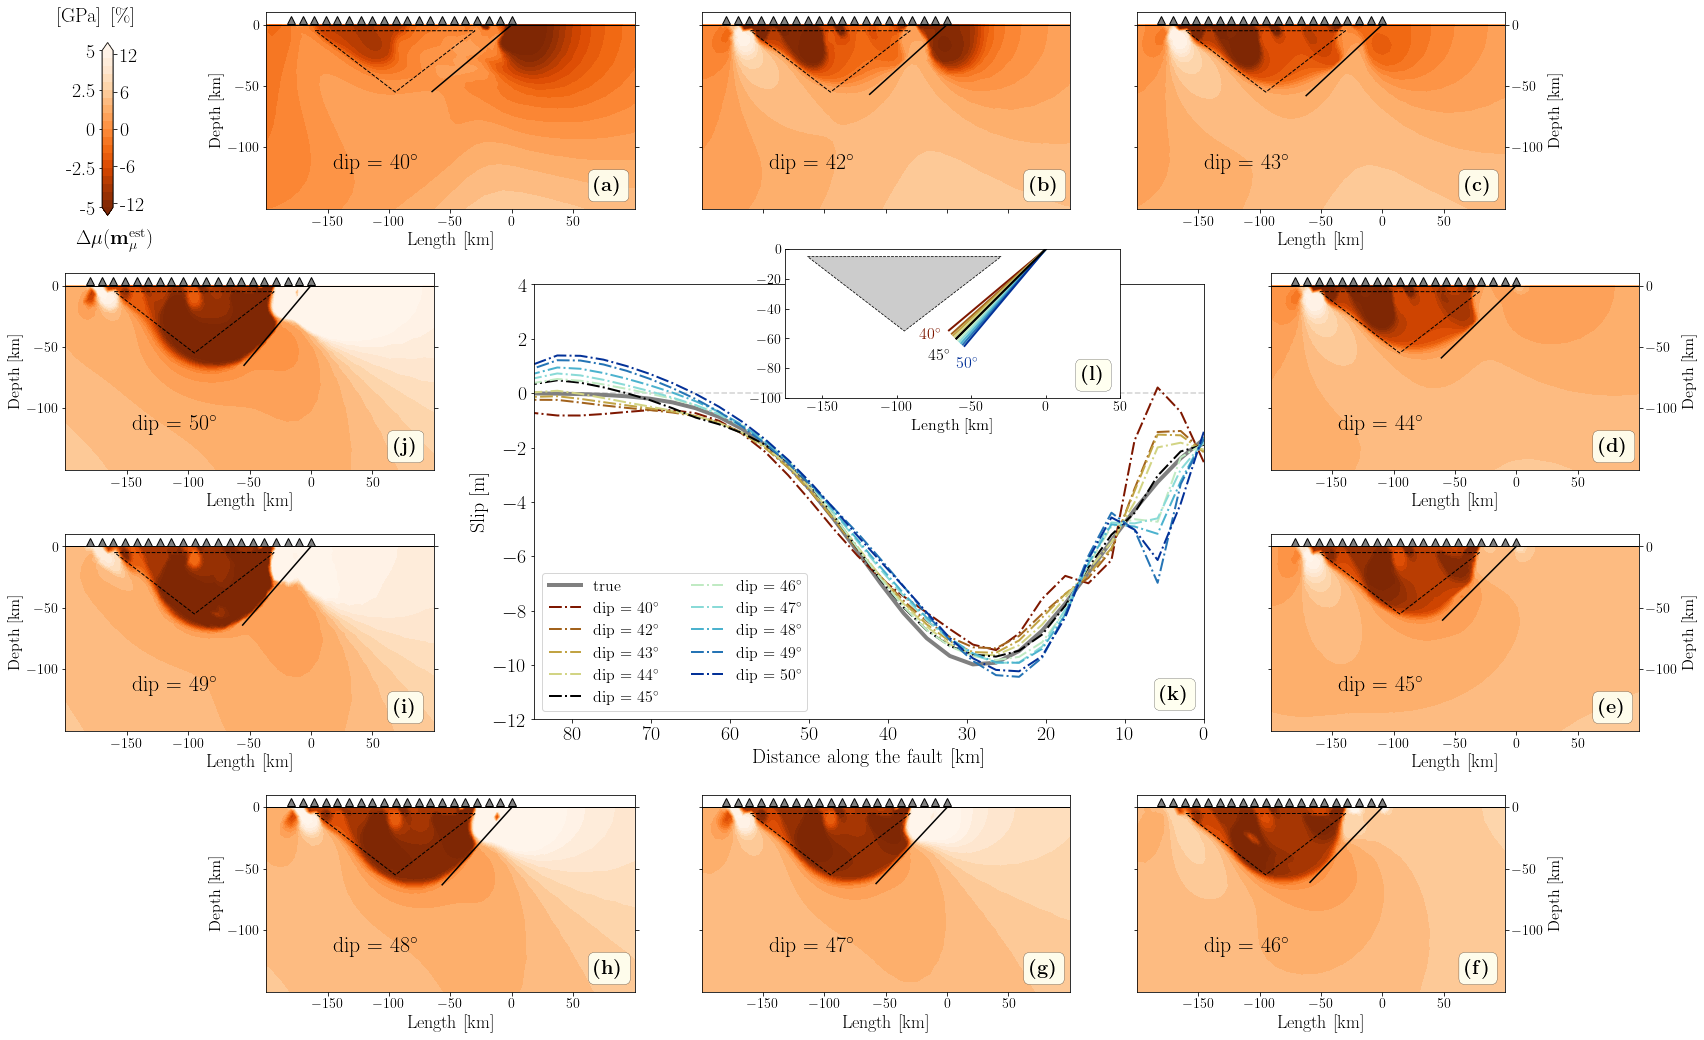

In [111]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12,8))

nseg_fault = len(yf_45)
L = np.sqrt(yf_45[0]**2 + xf_45[0]**2) 
width = np.linspace(0, L, nseg_fault) 

colors = [ cm.roma(0.), cm.roma(0.15), cm.roma(0.3), cm.roma(0.4), 'k', 
           cm.roma(0.5), cm.roma(0.6), cm.roma(0.7), cm.roma(0.85), cm.roma(1.) ]
linestyles = ['solid', 'dashed', 'dashdot']
lww = 2.0

choices = np.arange(0,10)
L, W = 0.55, 0.6
XX = [-0.7, -0.4, 0.25, 0.9, 1.1]
YY = [1.1, 0.5, -0.1, -0.7]

X = [ XX[1], XX[2], XX[3], XX[4], XX[4], XX[3], XX[2], XX[1], XX[0], XX[0] ]
Y = [ YY[0], YY[0], YY[0], YY[1], YY[2], YY[3], YY[3], YY[3], YY[2], YY[1] ]

# 
ax.plot(width, np.zeros(width.shape), '--', color='lightgray')
ax.plot(width, s_true_45, color='gray', ls=linestyles[0], lw=lww+2, 
        label=r'true')

for i, j in enumerate(choices):
    ax.plot(width, ms_s[j], color=colors[i], ls=linestyles[2], lw=lww, 
            label=texts[j])

ax.legend(loc='lower left', ncol=2, fontsize=16)
ax.set_xlim([min(width), max(width)])
ax.set_ylim([-12, 4])
ax.set_xlabel(r'Distance along the fault [km]')
ax.set_ylabel(r'Slip [m]')
ax.text(0.935, 0.08, letters[-2], transform=ax.transAxes, fontsize=SMALL_SIZE,
                        verticalalignment='top', bbox=props)    
ax.invert_xaxis()


# Put inset model setup
axins = ax.inset_axes([0.375, 0.735, 0.5, 0.35])
axins.set_aspect('equal')
for i, j in enumerate(choices):
    axins.plot(xfs[j], yfs[j], color=colors[i], ls=linestyles[0], lw=lww)

axins.plot(xf_45, yf_45, color='k', ls=linestyles[0], lw=lww)
axins.add_patch(Polygon(xy_triangle, facecolor='gray', edgecolor="none", alpha=0.4))
axins.add_patch(Polygon(xy_triangle, facecolor="none", edgecolor='k', linestyle=linestyles[1], lw=0.75))
axins.set_xlim((-175, 50)) 
axins.set_ylim((-100, 0.))
axins.text(-85, -60, r"$40^\circ$", color=colors[0], fontsize=16)
axins.text(-79, -74, r"$45^\circ$", color='k', fontsize=16)
axins.text(-60, -80, r"$50^\circ$", color=colors[9], fontsize=16)
axins.set_aspect('equal')
axins.tick_params(axis='both', which='major', direction='in', labelsize=14)
axins.tick_params(axis='both', which='minor', direction='in', labelsize=12)
axins.set_xlabel(r'Length [km]', fontsize=16)
#axins.set_ylabel(r'Depth [km]', fontsize=16)
axins.text(0.885, 0.22, letters[-1], transform=axins.transAxes, fontsize=SMALL_SIZE,
                        verticalalignment='top', bbox=props)    



# Plot the insets all around this central plot (create a function which plots)
for i, j in enumerate(choices):
    location = [X[i], Y[i], L, W]
    if i == 0:
        CS = plot_inset(meshes[j], Vhs[j], xfs[j], yfs[j], ms_mu[j], levels_m, texts[j], location, X[i], Y[i], 
                        letters[i], label_left=True, label_right=False, label_bottom=True)
    elif i == 1:
        CS = plot_inset(meshes[j], Vhs[j], xfs[j], yfs[j], ms_mu[j], levels_m, texts[j], location, X[i], Y[i], 
                        letters[i], label_left=False, label_right=False, label_bottom=False)
    elif i == 2:
        CS = plot_inset(meshes[j], Vhs[j], xfs[j], yfs[j], ms_mu[j], levels_m, texts[j], location, X[i], Y[i], 
                        letters[i], label_left=False, label_right=True, label_bottom=True)
    elif i == 3:
        CS = plot_inset(meshes[j], Vhs[j], xfs[j], yfs[j], ms_mu[j], levels_m, texts[j], location, X[i], Y[i], 
                        letters[i], label_left=False, label_right=True, label_bottom=True)
    elif i == 4:
        CS = plot_inset(meshes[j], Vhs[j], xfs[j], yfs[j], ms_mu[j], levels_m, texts[j], location, X[i], Y[i], 
                        letters[i], label_left=False, label_right=True, label_bottom=True)
    elif i == 5:
        CS = plot_inset(meshes[j], Vhs[j], xfs[j], yfs[j], ms_mu[j], levels_m, texts[j], location, X[i], Y[i], 
                        letters[i], label_left=False, label_right=True, label_bottom=True)
    elif i == 6:
        CS = plot_inset(meshes[j], Vhs[j], xfs[j], yfs[j], ms_mu[j], levels_m, texts[j], location, X[i], Y[i], 
                        letters[i], label_left=False, label_right=False, label_bottom=True)
    elif i == 7:
        CS = plot_inset(meshes[j], Vhs[j], xfs[j], yfs[j], ms_mu[j], levels_m, texts[j], location, X[i], Y[i], 
                        letters[i], label_left=True, label_right=False, label_bottom=True)
    elif i == 8:
        CS = plot_inset(meshes[j], Vhs[j], xfs[j], yfs[j], ms_mu[j], levels_m, texts[j], location, X[i], Y[i], 
                        letters[i], label_left=True, label_right=False, label_bottom=True)
    elif i == 9:
        CS = plot_inset(meshes[j], Vhs[j], xfs[j], yfs[j], ms_mu[j], levels_m, texts[j], location, X[i], Y[i], 
                        letters[i], label_left=True, label_right=False, label_bottom=True)


# Make a new Axes instance [left, bottom, width, height]
cbar_ax = plt.gcf().add_axes([-0.375, 1., 0.0125, 0.3])
cbar = plt.colorbar( CS, cax=cbar_ax, orientation="vertical", 
                    ticks=[-5., -2.5, 0., 2.5, 5.],
                    format="%.1f")
cbar.ax.set_yticklabels( ['-5', '-2.5', '0', '2.5', '5'] )
cbar.set_label(r'[GPa]', labelpad=-15, y=1.15, rotation=0)
plt.gcf().text(-0.405, 0.95, r'$\Delta\mu(\mathbf{m}^{\mathrm{est}}_{\mu})$', fontsize=SMALL_SIZE)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')
# Put second colorbar
cbar_ax2 = plt.gcf().add_axes([-0.375, 1., 0.0125, 0.3])
# Scale colorbar
mu_true_anomaly, mu_true_background = 26.49, 39.52
scaling = (5/mu_true_background)*100
scaling_ticks_ = np.array([-12, -6, 0., 6, 12])    
scaling_ticks = (5*scaling_ticks_/scaling).tolist()
cbar2 = plt.colorbar(CS, cax=cbar_ax2, ticks=scaling_ticks)
cbar2.ax.set_yticklabels( ['-12', '-6', '0', '6', '12'] )
cbar2.set_label(r'[\%]', labelpad=-20, y=1.275, rotation=0)


plt.show()
